In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import jaccard_score

In [ ]:

data_path = "/content/drive/MyDrive/Datasets/TUSimple/train_set"
label_file = '/content/drive/MyDrive/Datasets/TUSimple/train_set/label_data_0601.json'

with open(label_file, 'r') as f:
    labels = [json.loads(line) for line in f]


In [ ]:
def preprocess_data(data_path, labels, img_size=(512, 256)):
    images = []
    masks = []
    for label in labels:
        img_path = os.path.join(data_path, label['raw_file'])
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, img_size)

        mask = np.zeros((img_size[1], img_size[0]), dtype=np.uint8)

        lanes = label['lanes']
        h_samples = label['h_samples']

        scale_x = img_size[0] / 1280
        scale_y = img_size[1] / 720

        for lane in lanes:
            points = [(x, y) for (x, y) in zip(lane, h_samples) if x > 0]
            if len(points) < 2:
                continue
            for i in range(len(points) - 1):
                pt1 = (int(points[i][0] * scale_x), int(points[i][1] * scale_y))
                pt2 = (int(points[i+1][0] * scale_x), int(points[i+1][1] * scale_y))
                cv2.line(mask, pt1, pt2, 255, 5)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.expand_dims(np.array(masks) / 255.0, axis=-1)

images, masks = preprocess_data(data_path, labels)

In [ ]:
x_train_raw, x_temp, y_train_raw, y_temp = train_test_split(images, masks, test_size=0.2, random_state=42)

x_val_raw, x_test_raw, y_val_raw, y_test_raw = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class LaneDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.uint8)
        mask = (self.masks[idx] * 255).astype(np.uint8)

        if self.transform:
            seed = np.random.randint(2147483647)
            torch.manual_seed(seed)
            image = self.transform(image)
            torch.manual_seed(seed)
            mask = self.transform(mask)

        return image.float(), mask.float()


augment_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

plain_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])


train_dataset = LaneDataset(x_train_raw, y_train_raw, transform=augment_transform)
val_dataset   = LaneDataset(x_val_raw, y_val_raw, transform=plain_transform)
test_dataset  = LaneDataset(x_test_raw, y_test_raw, transform=plain_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:

class SmallUNet(nn.Module):
    def __init__(self):
        super(SmallUNet, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        self.enc1 = CBR(3, 32)
        self.enc2 = CBR(32, 64)
        self.enc3 = CBR(64, 128)
        self.enc4 = CBR(128, 256)
        self.enc5 = CBR(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = CBR(512, 1024)
        self.upconv5 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec5 = CBR(1024, 512)
        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec4 = CBR(512, 256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = CBR(256, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = CBR(128, 64)
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = CBR(64, 32)
        self.final = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        e5 = self.enc5(self.pool(e4))
        b = self.bottleneck(self.pool(e5))
        d5 = self.dec5(torch.cat((e5, self.upconv5(b)), dim=1))
        d4 = self.dec4(torch.cat((e4, self.upconv4(d5)), dim=1))
        d3 = self.dec3(torch.cat((e3, self.upconv3(d4)), dim=1))
        d2 = self.dec2(torch.cat((e2, self.upconv2(d3)), dim=1))
        d1 = self.dec1(torch.cat((e1, self.upconv1(d2)), dim=1))
        return torch.sigmoid(self.final(d1))


In [ ]:
import torch
import torch.nn as nn

class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        self.bce = nn.BCELoss()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return self.bce(inputs, targets) + 1 - dice

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SmallUNet().to(device)
criterion = DiceBCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


In [ ]:
num_epochs = 100

train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"✅ En iyi model kaydedildi! [Val Loss: {best_val_loss:.4f}]")

        print(f"✅ En iyi model kaydedildi! [Val Loss: {best_val_loss:.4f}]")



Epoch [1/100] | Train Loss: 1.5249 | Val Loss: 1.6804
✅ En iyi model kaydedildi! [Val Loss: 1.6804]
✅ En iyi model kaydedildi! [Val Loss: 1.6804]
Epoch [2/100] | Train Loss: 1.3192 | Val Loss: 1.3047
✅ En iyi model kaydedildi! [Val Loss: 1.3047]
✅ En iyi model kaydedildi! [Val Loss: 1.3047]
Epoch [3/100] | Train Loss: 1.2365 | Val Loss: 1.1858
✅ En iyi model kaydedildi! [Val Loss: 1.1858]
✅ En iyi model kaydedildi! [Val Loss: 1.1858]
Epoch [4/100] | Train Loss: 1.1860 | Val Loss: 1.1409
✅ En iyi model kaydedildi! [Val Loss: 1.1409]
✅ En iyi model kaydedildi! [Val Loss: 1.1409]
Epoch [5/100] | Train Loss: 1.1405 | Val Loss: 1.1151
✅ En iyi model kaydedildi! [Val Loss: 1.1151]
✅ En iyi model kaydedildi! [Val Loss: 1.1151]
Epoch [6/100] | Train Loss: 1.0941 | Val Loss: 1.0607
✅ En iyi model kaydedildi! [Val Loss: 1.0607]
✅ En iyi model kaydedildi! [Val Loss: 1.0607]
Epoch [7/100] | Train Loss: 1.0471 | Val Loss: 1.0111
✅ En iyi model kaydedildi! [Val Loss: 1.0111]
✅ En iyi model kaydedild

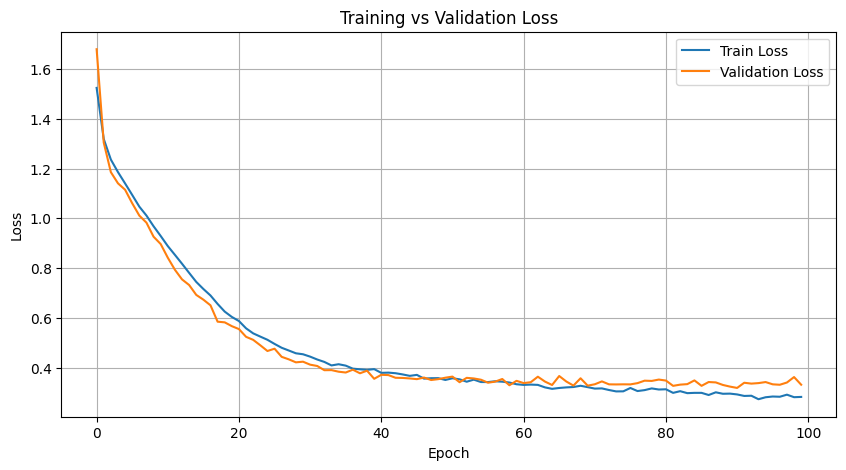

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def dice_score(preds, targets, threshold=0.5, smooth=1e-6):
    preds = (preds > threshold).float()
    targets = targets.float()

    intersection = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))

    score = (2 * intersection + smooth) / (union + smooth)
    return score.mean().item()
def iou_score(preds, targets, threshold=0.5, smooth=1e-6):
    preds = (preds > threshold).float()
    targets = targets.float()

    intersection = (preds * targets).sum(dim=(1,2,3))
    union = (preds + targets).clamp(0, 1).sum(dim=(1,2,3))

    iou = (intersection + smooth) / (union + smooth)
    return iou.mean().item()


In [ ]:
model.eval()
dice_total = 0.0
iou_total = 0.0
n_batches = 0

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        preds = model(images)

        dice_total += dice_score(preds, masks)
        iou_total += iou_score(preds, masks)
        n_batches += 1

avg_dice = dice_total / n_batches
avg_iou = iou_total / n_batches

print(f"🎯 Dice Score: {avg_dice:.4f}")
print(f"🎯 IoU Score: {avg_iou:.4f}")


🎯 Dice Score: 0.7559
🎯 IoU Score: 0.6136


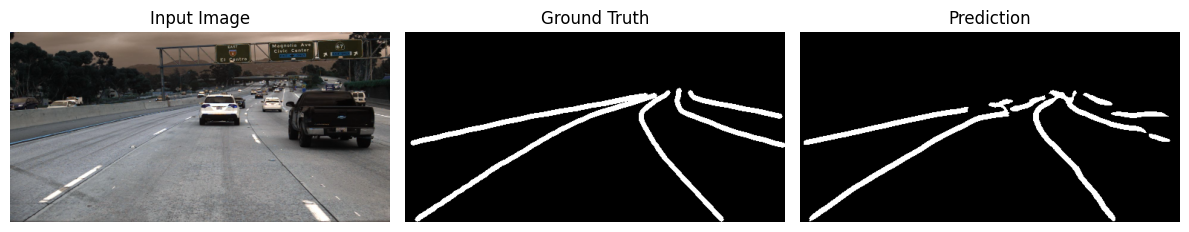

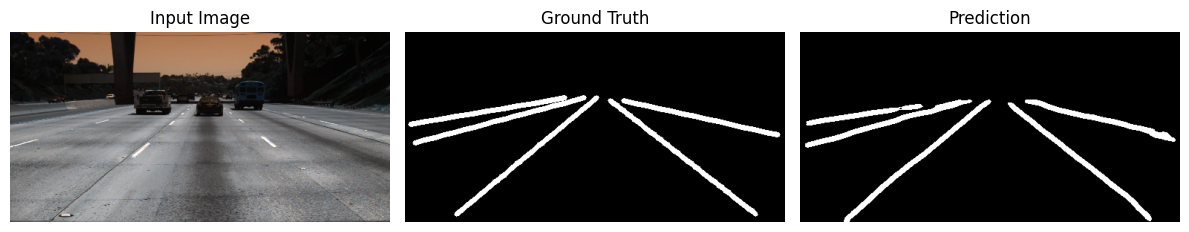

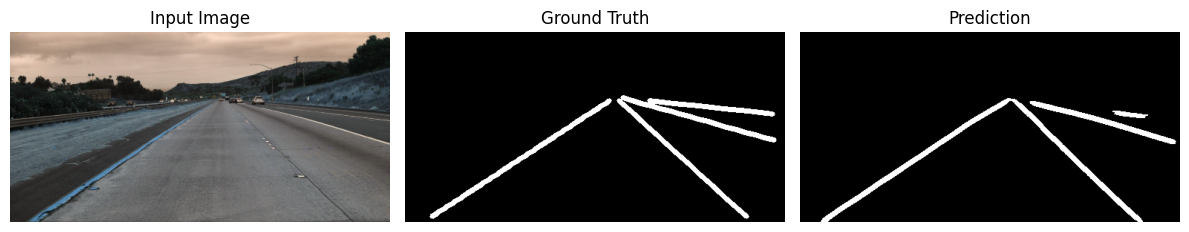

In [ ]:
import matplotlib.pyplot as plt

model.eval()

images, masks = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    preds = model(images)

for i in range(3):
    input_img = images[i].permute(1, 2, 0).cpu().numpy()
    true_mask = masks[i][0].cpu().numpy()
    pred_mask = preds[i][0].cpu().numpy() > 0.5

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(input_img)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Prediction")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


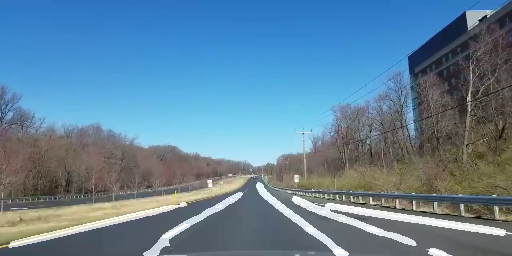

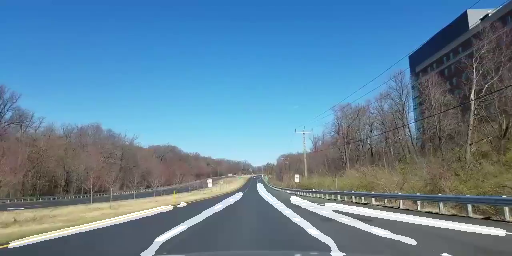

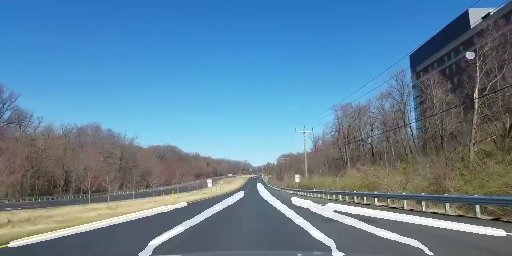

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import torch
import numpy as np
from torchvision import transforms

model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.to(device)
model.eval()

cap = cv2.VideoCapture('/content/drive/MyDrive/test.mp4')
output_size = (512, 256)

frame_count = 0
max_frames_to_show = 3

while cap.isOpened() and frame_count < max_frames_to_show:
    ret, frame = cap.read()
    if not ret:
        break

    img = cv2.resize(frame, output_size)
    img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img_tensor)[0][0].cpu().numpy()
        mask = (pred > 0.5).astype(np.uint8) * 255
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    overlay = cv2.addWeighted(img, 1.0, mask, 0.5, 0)
    cv2_imshow(overlay)
    frame_count += 1

cap.release()


In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('/content/drive/MyDrive/lane_output.mp4', fourcc, 20.0, output_size)

cap = cv2.VideoCapture('/content/drive/MyDrive/test.mp4')

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    img = cv2.resize(frame, output_size)
    img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img_tensor)[0][0].cpu().numpy()
        mask = (pred > 0.5).astype(np.uint8) * 255
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    overlay = cv2.addWeighted(img, 1.0, mask, 0.5, 0)
    out.write(overlay)

cap.release()
out.release()
print("✅ Video kaydedildi: /content/drive/MyDrive/lane_output.mp4")


✅ Video kaydedildi: /content/drive/MyDrive/lane_output.mp4
